In [1]:
import matplotlib.pyplot as mp
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import statsmodels.tools.eval_measures as em
import os
from easy_mpl import regplot, plot
import numpy as np
from sklearn.impute import KNNImputer
import seaborn as sns

In [2]:
# Assuming X_train, X_test, y_train, y_test are defined and available
file_path = 'ML_photocatalysis2.xlsx'

# Read the Excel file
data = pd.read_excel(file_path, header=0)

# Assuming 'df' is your pandas DataFrame.
df = data.sample(frac=1, random_state=38).reset_index(drop=True)

# Separate the features and the target variable
X = df[['Ni to TiO2 ratio', 'gC3N4 to TiO2 ratio', 'dosage', 'Time']]
y = df['SA removal rate']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100, 50), (100, 50, 100)],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
}

# Initialize the MLPRegressor model
regr = MLPRegressor(random_state=42, max_iter=10000)
# regr = MLPRegressor(random_state=42, max_iter=10000, activation='logistic')
activation='tanh'
# Initialize the Grid Search model
grid_search = GridSearchCV(regr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best model
best_model_MLP = grid_search.best_estimator_

# Predictions
y_pred_test = best_model_MLP.predict(X_test_scaled)
y_pred_train = best_model_MLP.predict(X_train_scaled)

# Evaluate the model
n_test = X_test_scaled.shape[0]  # Number of observations
p_test = X_test_scaled.shape[1]  # Number of predictors
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_adjusted_r_squared = 1 - (1 - test_r2) * (n_test - 1) / (n_test - p_test - 1)

n_train = X_train_scaled.shape[0]  # Number of observations
p_train = X_train_scaled.shape[1]  # Number of predictors
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_adjusted_r_squared = 1 - (1 - train_r2) * (n_train - 1) / (n_train - p_train - 1)

print(f'Best model parameters: {grid_search.best_params_}')
print(f'MSE_test: {test_mse}, R2_test: {test_r2}, Adjust_R2_test: {test_adjusted_r_squared}')
print(f'MSE_train: {train_mse}, R2_train: {train_r2}, Adjust_R2_train: {train_adjusted_r_squared}')

# Note: BIC calculation is omitted as it requires a specific function `calculate_log_likelihood_from_mse` and `em.bic`
# which are not standard in sklearn and need to be defined.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best model parameters: {'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
MSE_test: 0.0012766163811221791, R2_test: 0.9776072845197046, Adjust_R2_test: 0.9741622513688899
MSE_train: 0.001733954896552702, R2_train: 0.9653365043539711, Adjust_R2_train: 0.9641514275797479


In [12]:
import numpy as np
import pandas as pd
from itertools import product

# Define the columns as numpy arrays
column1 = np.arange(0, 10.1, 0.1)
column2 = np.arange(0, 2.6, 0.1)
column3 = np.arange(0, 1.6, 0.1)
column4 = np.arange(3, 5.1, 0.1)

# Create all combinations of the four columns
all_combinations = list(product(column1, column2, column3, column4))

# Convert to a pandas DataFrame
df = pd.DataFrame(all_combinations, columns=['Column 1', 'Column 2', 'Column 3', 'Column 4'])

df_y = best_model_MLP.predict(df)
df_y = pd.DataFrame(df_y)

# Define the path for the Excel file
excel_filename = 'df_y.xlsx'

# Save the DataFrame to an Excel file
df_y.to_excel(excel_filename, index=False)
# Assuming df is your primary DataFrame and df_y is the data you want to add as a new column
if isinstance(df_y, np.ndarray):
    df_y = pd.DataFrame(df_y)

df['y'] = df_y.iloc[:,0]  

# print(df)
df = df[df['y'] <= 1]

# Display the DataFrame after the operation
max_y_index = df['y'].idxmax()

# Retrieve the row with the largest 'y' value
row_with_max_y = df.loc[max_y_index]

# # Display the row
# print(row_with_max_y)

/Users/xiaotongsun/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


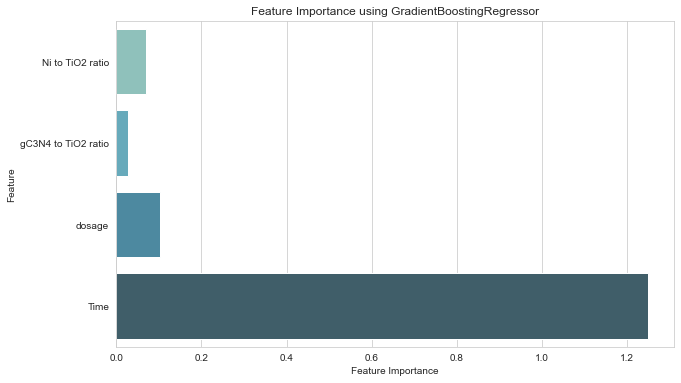

In [5]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
feature_names = X.columns
# Assuming `best_model_MLP` is your trained MLPRegressor model and `X_test_scaled` is your scaled test dataset
result = permutation_importance(best_model_MLP, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importance of each feature
feature_importance = result.importances_mean

# Now let's plot this information
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create a bar plot
sns.barplot(x=feature_importance, y=feature_names, palette="GnBu_d")

# Add chart labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using GradientBoostingRegressor')

plt.show()


In [14]:
import numpy as np
import pandas as pd

# Generating x1 with values from 0.1 to 10, interval of 0.1
x1 = np.arange(0.1, 10.1, 0.01)

# Generating x2, x3, x4 with fixed values
x2 = np.full_like(x1, 1.5)
x3 = np.full_like(x1, 0.75)
x4 = np.full_like(x1, 4.5)

# Creating a DataFrame
data_fix_x1 = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4})

# Display the first few rows of the DataFrame
data_fix_x1.head()
df_y1 = best_model_MLP.predict(data_fix_x1)
if isinstance(df_y1, np.ndarray):
    df_y1 = pd.DataFrame(df_y1)

data_fix_x1['y'] = df_y1.iloc[:,0]  
# print(data_fix_x1)
min_y_index = data_fix_x1['y'].idxmin()

# Retrieve the row with the largest 'y' value
row_with_min_y = data_fix_x1.loc[min_y_index]

# Display the row
# print(row_with_min_y)
max_y_index = data_fix_x1['y'].idxmax()

# Retrieve the row with the largest 'y' value
row_with_max_y = data_fix_x1.loc[max_y_index]

# Display the row
# print(row_with_max_y)


/Users/xiaotongsun/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [7]:
import numpy as np
import pandas as pd
from itertools import product

# Define the columns as numpy arrays
column1 = np.arange(0, 10.1, 0.1)
column2 = np.arange(0, 2.6, 0.1)
column3 = np.arange(0, 1.6, 0.1)
column4 = np.arange(3, 5.1, 0.1)

# Create all combinations of the four columns
all_combinations = list(product(column1, column2, column3, column4))

# Convert to a pandas DataFrame
df_all_combinations = pd.DataFrame(all_combinations, columns=['Column 1', 'Column 2', 'Column 3', 'Column 4'])


# excel_filename = 'optimization_combination.xlsx'

# # Save the reduced DataFrame to an Excel file
# df.to_excel(excel_filename, index=False)


# df_all_combinations.head()


In [8]:
import numpy as np
import pandas as pd

# Generating x1 with values from 0.1 to 10, interval of 0.1
x1 = np.arange(0.1, 10.1, 0.01)

# Generating x2 with values from 0.1 to 2.5, interval of 0.1
x2 = np.arange(0.1, 2.6, 0.01)

# Ensuring x1 and x2 have the same length by repeating x2 values
repeat_factor = len(x1) // len(x2) + 1
x2 = np.tile(x2, repeat_factor)[:len(x1)]

# Generating x3, x4 with fixed values
x3 = np.full_like(x1, 0.75)
x4 = np.full_like(x1, 4.5)

# Creating a DataFrame
df_fix_x3_x4 = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4})

df_y_fix_x3_x4 = best_model_MLP.predict(df_fix_x3_x4)
if isinstance(df_y_fix_x3_x4, np.ndarray):
    df_y_fix_x3_x4 = pd.DataFrame(df_y_fix_x3_x4)

df_fix_x3_x4['y'] = df_y_fix_x3_x4.iloc[:,0] 


/Users/xiaotongsun/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


<ipython-input-9-83ca8d08e4dc>:21: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X1, X2, Y, cmap='viridis', edgecolor='none')


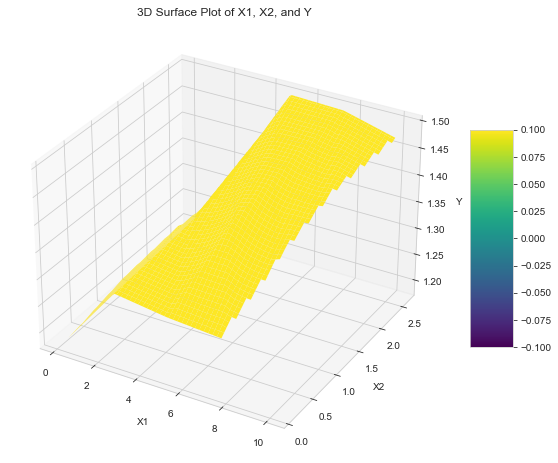

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np
import pandas as pd



# Creating a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Creating a meshgrid for the surface plot
X1, X2 = np.meshgrid(np.linspace(min(df_fix_x3_x4['x1']), max(df_fix_x3_x4['x1']), 100),
                     np.linspace(min(df_fix_x3_x4['x2']), max(df_fix_x3_x4['x2']), 100))

# Interpolating the y-values on this grid
Y = griddata((df_fix_x3_x4['x1'], df_fix_x3_x4['x2']), df_fix_x3_x4['y'], (X1, X2), method='linear')

# Plotting the surface
surf = ax.plot_surface(X1, X2, Y, cmap='viridis', edgecolor='none')

# Setting labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# Title
ax.set_title('3D Surface Plot of X1, X2, and Y')

# Adding a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [10]:
import numpy as np
import pandas as pd

# Generating x1 with values from 0.1 to 10, interval of 0.1
x1 = np.arange(0.1, 10.1, 0.01)

# Generating x2 with values from 0.1 to 2.5, interval of 0.1
x3 = np.arange(0.1, 1.5, 0.01)

# Ensuring x1 and x2 have the same length by repeating x2 values
repeat_factor = len(x1) // len(x3) + 1
x3 = np.tile(x3, repeat_factor)[:len(x1)]

# Generating x3, x4 with fixed values
x2 = np.full_like(x1, 1.5)
x4 = np.full_like(x1, 4.5)

# Creating a DataFrame
data_fix_x1_x3 = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4})


df_y_fix_x1_x3 = best_model_MLP.predict(data_fix_x1_x3)
if isinstance(df_y_fix_x1_x3, np.ndarray):
    df_y_fix_x1_x3 = pd.DataFrame(df_y_fix_x1_x3)

data_fix_x1_x3['y'] = df_y_fix_x1_x3.iloc[:,0] 



/Users/xiaotongsun/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


<ipython-input-11-752d575792ed>:13: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax.plot_surface(X1, X3, Y, cmap='viridis', edgecolor='none')


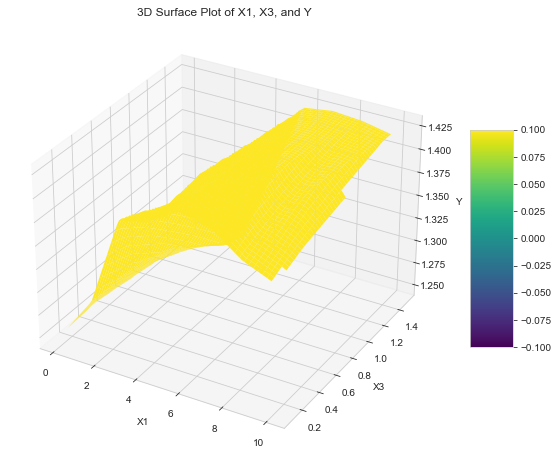

In [11]:
# Creating a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Creating a meshgrid for the surface plot
X1, X3 = np.meshgrid(np.linspace(min(data_fix_x1_x3['x1']), max(data_fix_x1_x3['x1']), 100),
                     np.linspace(min(data_fix_x1_x3['x3']), max(data_fix_x1_x3['x3']), 100))

# Interpolating the y-values on this grid
Y = griddata((data_fix_x1_x3['x1'], data_fix_x1_x3['x3']), data_fix_x1_x3['y'], (X1, X3), method='linear')

# Plotting the surface
surf = ax.plot_surface(X1, X3, Y, cmap='viridis', edgecolor='none')

# Setting labels
ax.set_xlabel('X1')
ax.set_ylabel('X3')
ax.set_zlabel('Y')

# Title
ax.set_title('3D Surface Plot of X1, X3, and Y')

# Adding a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()